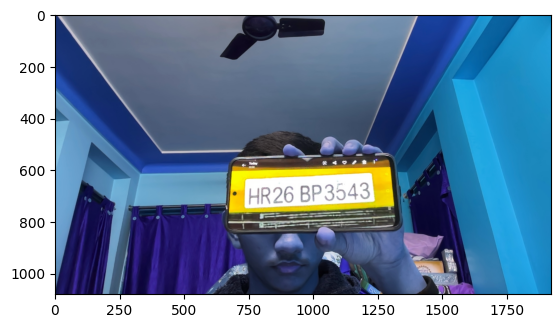

Car with number plate - HR26BP3543 has entered the garage successfully!!


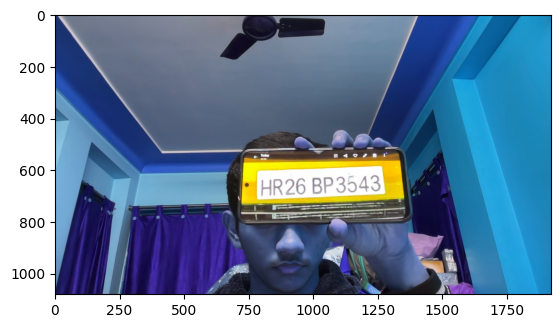

Car with number plate - HR26BP3543 is already there in the garage.


KeyboardInterrupt: 

In [17]:
# imports
import cv2
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.filters import gaussian
from skimage.measure import label, regionprops
from skimage.util import invert
from scipy.spatial.distance import euclidean
from PIL import Image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pymongo as pym
import difflib
import threading
import datetime
import time
import requests

def most_similar_plate(target_plate):
    '''
    function to extract the most similar number plate from mongoDB
    '''
    client = pym.MongoClient("your_mongodb_url")
    db = client["fmg_personal"]
    collection = db["car_data"]
    key_to_retrieve = "licenseId"
    result = collection.find({}, { "_id": 0, key_to_retrieve: 1 })
    license_list = [it["licenseId"] for it in result]
    most_similar_plate = difflib.get_close_matches(target_plate, license_list, n=1)[0]
    return most_similar_plate
    
def get_plate(img_path, model_alpha_path='model_alpha.h5', model_num_path='model_2_more_layers_num.h5'):
    '''
    function to extract alphanumeric characters(of a number plate) from an image of a car
    '''
    try:
        # read the image and convert it to grayscale
        car = imread(img_path)
        
        gray_img=[]
        
        # if there are 3 channels to the image, convert it to grayscale
        if car.shape[2] == 3:
            gray_img = rgb2gray(car)
        else:
            gray_img = rgb2gray(rgba2rgb(car))

        # blur the image to remove any noise
        blurred_gray_img = gaussian(gray_img)
        
        thresh = 0.46 # experimentally calculated through otsu thresholding
        binary = invert(gray_img > thresh)
        label_image = label(binary, connectivity=2) # Find connected regions

        text_like_regions = []
        for region in regionprops(label_image):
            minr, minc, maxr, maxc = region.bbox
            w = maxc - minc
            h = maxr - minr

            asr = w/h # aspect ratio

            region_area = w*h

            wid,hei = blurred_gray_img.shape
            img_area = wid*hei

            
            if region_area > img_area/5000 and region_area < (0.2 * img_area) and asr < 1:
                text_like_regions.append(region)

        all_points = []
        for region in text_like_regions:
            minr, minc, maxr, maxc = region.bbox
            all_points.append([minc, minr, maxc, maxr])

        # Define the threshold for ymin, ymax difference and area similarity
        y_threshold = 5  # Adjust this value as needed

        # Sort the list of bounding boxes based on ymin (y-coordinate)
        sorted_boxes = sorted(all_points, key=lambda box: box[1])

        groups = []
        current_group = []

        # Iterate over the sorted boxes
        for box in sorted_boxes:
            if not current_group:
                current_group.append(box)
            else:
                prev_box = current_group[-1]
                ymin_diff = abs(box[1] - prev_box[1])
                ymax_diff = abs(box[3] - prev_box[3])

                if ymin_diff <= y_threshold and ymax_diff <= y_threshold :
                    current_group.append(box)
                else:
                    if len(current_group) >= 10:
                        groups.append(current_group[:10])  # Extract the first 10 bounding boxes
                    current_group = [box]

        # Check if the last group satisfies the condition
        if len(current_group) >= 10:
            groups.append(current_group[:10])  # Extract the first 10 bounding boxes
        
        groups = sorted(groups[0], key=lambda box: box[0])


        alpha = load_model(model_alpha_path, compile=False)
        num = load_model(model_num_path, compile=False)
        predictions = []
        # Load the image containing the license plate
        image_path = img_path
        image = cv2.imread(image_path)

        # Define the license plate coordinates
        license_plate_coords = groups

        # Perform OCR on each license plate coordinate
        for index, coords in enumerate(license_plate_coords):
            # Crop the license plate region
            xmin, ymin, xmax, ymax = coords
            license_plate = image[ymin:ymax, xmin:xmax]
            license_plate = cv2.resize(license_plate, (128, 128))
            # Add an extra dimension to represent the batch size
            x = np.expand_dims(license_plate, axis=0)

            if index in [0, 1, 4, 5]:
                # only 0, 1, 4, 5th index of number plates contain alphabets
                prediction = np.argmax(alpha.predict((x/255.), verbose=0))
                predictions.append(chr(ord('A') + prediction))
            else:
                # rest of the indices contain numbers
                prediction = np.argmax(num.predict((x/255.), verbose=0))
                predictions.append(chr(ord('0') + prediction))

        string_array = [str(item) for item in predictions]
        intermediate_result = "".join(string_array)
        return most_similar_plate(intermediate_result)
    except:
        return "No Plate Found"


    
    
# scheduler functions
def check_consistency(text, length):
    '''
    function to verify the character length of the numberplate
    '''
    return len(text) == length

def capture_predict_and_call_api():
    '''
    function to call the get_plate function and call the required api
    '''
    global failsafe
    failsafe = 0
    while True:
        cap = cv2.VideoCapture(0)
        ret, frame = cap.read()

        filename = "image.jpeg"

        cv2.imwrite(filename, frame)
        image = cv2.imread(filename)

        plt.imshow(image, cmap="gray")
        plt.show()

        try:
            prediction = get_plate("image.jpeg")
            # print(prediction)
        except:
            prediction = ""
            print("No Number Plate Found")

        consistent = check_consistency(prediction, 10)

        if consistent or failsafe == 3:
            url = 'http://127.0.0.1:5001/bookings/accept/'
            payload = {
                "cameraId": "64aafe984058a8b7aba7fb31",
                "type": "in", # change this if the car is exiting the garage/parking
                "licenseId": prediction
            }
            failsafe = 0

            response = requests.post(url, json=payload)
            response_json = response.json()
            
            # print(response_json)

            # output messages for specific cases
            if response_json['message'] == "Booking created successfully":
                print(f"Car with number plate - {prediction} has entered the garage successfully!!")
            elif response_json['message'] == "User already has a booking":
                print(f"Car with number plate - {prediction} is already there in the garage.")
            elif response_json['message'] == "Booking updated successfully":
                print(f"Car with number plate - {prediction} left the garage successfully!!")
            elif response_json['message'] == "No booking found":
                print(f"Car with number plate - {prediction} is not in the garage.")
            
        # Handle the response data here if needed
        else:
            print("Request failed")
            failsafe += 1

        time.sleep(5)


capture_predict_and_call_api()